In [1]:
# python 3.7.3+
# contact@leonardofilipe.com

# For yahoo finance
import io
import re
import requests

# The usual suspects
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

# Tree models and data pre-processing
from numpy               import vstack, hstack
from sklearn             import tree

# Implicit datetime converter
from pandas.plotting     import register_matplotlib_converters
register_matplotlib_converters()

# Fancy graphics
plt.style.use('seaborn')

# Getting Yahoo finance data
def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

# A (lagged) technical indicator (Average True Range)
def ATR(df, n):
    df = df.reset_index()
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = (max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) -
              min(df.loc[i + 1, 'Low'], df.loc[i, 'Close']))
        TR_l.append(TR)
        i = i + 1
    return pd.Series(TR_l).ewm(span=n, min_periods=n).mean()

# Assets under consideration
tickers = ['PEP','KO']

data = None
while data is None:
    try:
        data = getdata(tickers,'946685000','1558566000','1d')
    except:
         pass

KO = data['KO']
KO = KO.drop('Volume',axis=1)
PEP = data['PEP']
PEP = PEP.drop('Volume',axis=1)
PEP.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-05-16,129.369995,130.750000,128.759995,130.270004,130.270004
2019-05-17,129.919998,130.869995,129.649994,130.509995,130.509995
2019-05-20,130.039993,130.449997,129.550003,129.990005,129.990005
2019-05-21,130.580002,130.580002,128.850006,129.050003,129.050003
2019-05-22,129.100006,130.639999,128.948303,130.070007,130.070007


In [2]:
variables = pd.DataFrame({'TPEP':(PEP['Close']/PEP['Close'].shift(7)-1).shift(1),
                      'TKO':(KO['Close']/KO['Close'].shift(6)-1).shift(1)})

variables['Target'] = variables.min(axis=1)
variables['IsPEP'] = variables['Target'].isin(variables['TPEP'])

variables['Open'] = np.where(variables['Target'].isin(variables['TPEP']),
                             PEP['Open'],
                             KO['Open'])

variables['Close'] = np.where(variables['Target'].isin(variables['TPEP']),
                              PEP['Close'],
                              KO['Close'])

variables['Returns'] = variables['Close']/variables['Open']-1

variables['APEP'] = PEP['Open']
variables['AKO'] = KO['Open']

variables = variables.reset_index().drop('Date',axis=1)

variables['ATR'] = ATR(PEP,40)

variables = variables.dropna()
variables = variables.reset_index().drop('index',axis=1)

# This is a minimalistic example, adding more information
#(both fundamental and technical) will much likely yield better results
features  = ['IsPEP','AKO','ATR','APEP']

In [3]:
training = 38
testing = 3

d1, d2, d3 = [], [], []

# Rolling calibration and testing of the Decision Tree Regressors
for ii in range(0, len(variables)-(training+testing), testing):
    X, y = [], []

    iam  = ii+training
    lazy = ii+training+testing

    # Training the model with the last 38 days
    for i in range(ii, iam):
        X.append([variables.iloc[i][var] for var in features])
        y.append(variables.iloc[i].Close)

    model = tree.DecisionTreeRegressor(max_depth=19, min_samples_leaf=3, min_samples_split=16)
    model.fit(vstack(X), hstack(y))

    XX = []

    # Testing it out-of-sample, its used for the next 3 days
    for i in range(iam, lazy):
        XX.append([variables.iloc[i][var] for var in features])

    predclose = pd.Series(model.predict(vstack(XX)),variables[iam:lazy].index)
    mret = variables['Returns'][iam:lazy]
    popen = variables['Open'][iam:lazy]

    # We trade if the predicted close price is superior to the open price
    trades = pd.Series(np.where(predclose > popen, mret, np.nan),variables[iam:lazy].index)

    # Exporting data
    try:
        d1.append(trades[iam])
        d2.append(trades[iam+1])
        d3.append(trades[iam+2])
    except:
        0

stitching = np.zeros(len(d1)+len(d2)+len(d3))

# Reassembling predictions
for i in range(0,len(d3)):
    stitching[i*3] = d1[i]
    stitching[i*3+1] = d2[i]
    stitching[i*3+2] = d3[i]

returns = pd.Series(stitching,PEP[-len(stitching):].index)

In [4]:
CompRes = pd.DataFrame({'Baseline': variables[-len(returns):].set_index(PEP[-len(returns):].index)['Returns'],
                        'DTR': returns})
CompRes['Baseline'].describe()

count    4797.000000
mean        0.000663
std         0.010995
min        -0.089762
25%        -0.004789
50%         0.000454
75%         0.005913
max         0.106294
Name: Baseline, dtype: float64

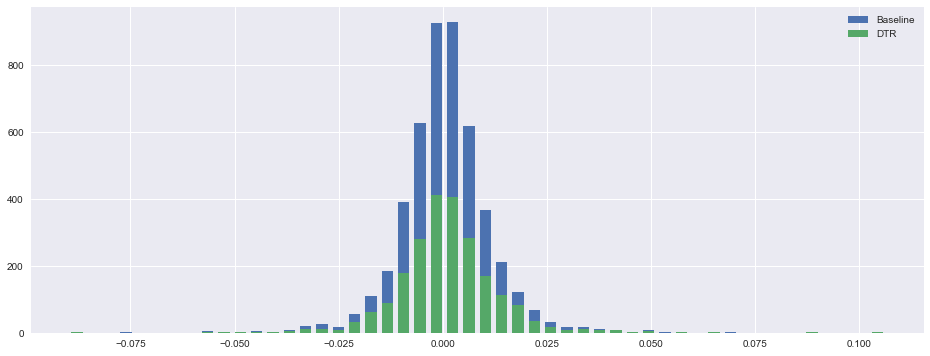

count    2246.000000
mean        0.001075
std         0.012123
min        -0.089762
25%        -0.004989
50%         0.000714
75%         0.006932
max         0.106294
Name: DTR, dtype: float64

In [5]:
fig, ax = plt.subplots(figsize=(16,6))

hist1, bins1 = np.histogram(CompRes['Baseline'].dropna(), bins=50)
width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2

hist2, bins2 = np.histogram(CompRes['DTR'].dropna(), bins=50)
width2 = 0.7 * (bins2[1] - bins2[0])
center2 = (bins2[:-1] + bins2[1:]) / 2

ax.bar(center1, hist1, align='center', width=width1, label='Baseline')
ax.bar(center2, hist2, align='center', width=width2, label='DTR')

plt.legend()
plt.show()
CompRes['DTR'].describe()

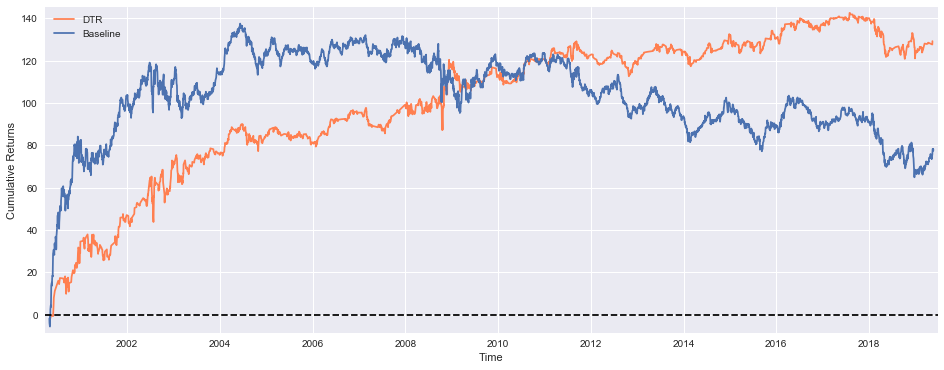

In [6]:
tc = -0.0005 #Simulating 0.05% transaction costs

plt.figure(figsize=(16,6))
plt.plot(((CompRes['DTR'].dropna()+tc).cumsum())*100, color='coral')
plt.plot(((CompRes['Baseline']+tc).cumsum())*100)
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

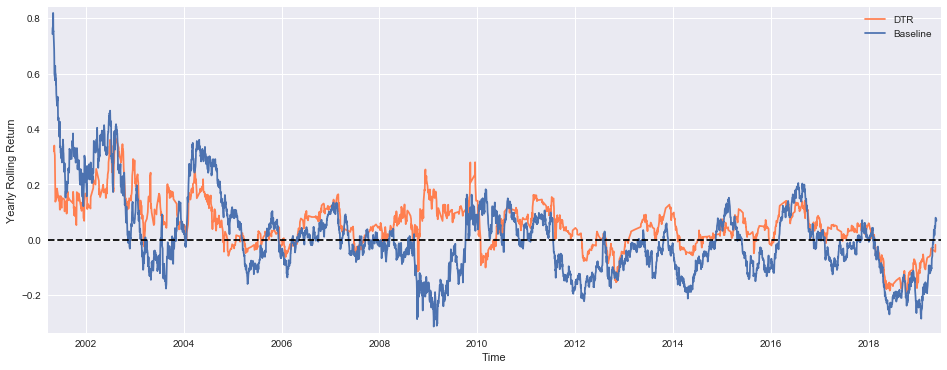

count    2128.000000
mean        0.056317
std         0.091666
min        -0.198393
25%         0.002925
50%         0.051458
75%         0.110358
max         0.373321
Name: DTR, dtype: float64

In [7]:
plt.figure(figsize=(16,6))
plt.plot((CompRes['DTR'].dropna()+tc).rolling(window=119).sum(), color='coral')
plt.plot((CompRes['Baseline']+tc).rolling(window=252).sum())
plt.xlabel('Time')
plt.ylabel('Yearly Rolling Return')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
# Descriptive statistics of the strategy rolling yearly return
#(assuming 119 trades per year)
((CompRes['DTR'].dropna()+tc).rolling(window=119).sum()).describe()